# Створення нейронної мережі

У цьому завданні ми створимо повнозв'язну нейронну мережу, використовуючи при цьому низькорівневі механізми tensorflow.

Архітектура нейромережі представлена на наступному малюнку. Як бачиш, у ній є один вхідний шар, два приховані, а також вихідний шар. В якості активаційної функції у прихованих шарах буде використовуватись сигмоїда. На вихідному шарі ми використовуємо softmax.

Частина коду зі створення мережі вже написана, тобі потрібно заповнити пропуски у вказаних місцях.

## Архітектура нейронної мережі

<img src="http://cs231n.github.io/assets/nn1/neural_net2.jpeg" alt="nn" style="width: 400px;"/>


## Про датасет MNIST

Дану нейромережу ми будемо вивчати на датасеті MNIST. Цей датасет являє собою велику кількість зображень рукописних цифр розміром $28 \times 28$ пікселів. Кожен піксель приймає значення від 0 до 255.

Як і раніше, датасет буде розділений на навчальну та тестову вибірки. При цьому ми виконаємо нормалізацію всіх зображень, щоб значення пікселів знаходилось у проміжку від 0 до 1, розділивши яскравість кожного пікселя на 255.

Окрім того, архітектура нейронної мережі очікує на вхід вектор. У нашому ж випадку кожен об'єкт вибірки являє собою матрицю. Що ж робити? У цьому завданні ми "розтягнемо" матрицю $28 \times 28$, отримавши при цьому вектор, що складається з 784 елементів.

![MNIST Dataset](https://www.researchgate.net/profile/Steven-Young-5/publication/306056875/figure/fig1/AS:393921575309346@1470929630835/Example-images-from-the-MNIST-dataset.png)

Більше інформації про датасет можна знайти [тут](http://yann.lecun.com/exdb/mnist/).

In [103]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import keras as K
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

In [94]:
num_classes = 10  # загальна кількість класів, у нашому випадку це цифри від 0 до 9
num_features = 784  # кількість атрибутів вхідного вектора 28 * 28 = 784

learning_rate = 0.001  # швидкість навчання нейронної мережі
training_steps = 3000  # максимальне число епох
batch_size = 256  # перераховувати ваги мережі ми будемо не на всій вибірці, а на її випадковій підмножині з batch_size елементів
display_step = 100  # кожні 100 ітерацій ми будемо показувати поточне значення функції втрат і точності

n_hidden_1 = 128  # кількість нейронів 1-го шару
n_hidden_2 = 256  # кількість нейронів 2-го шару

In [95]:
# from tensorflow.keras.datasets import mnist
from keras.datasets import mnist

# Завантажуємо датасет
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# Перетворюємо цілочисельні пікселі на тип float32
x_train, x_test = np.array(x_train, np.float32), np.array(x_test, np.float32)

# Перетворюємо матриці розміром 28x28 пікселів у вектор з 784 елементів
x_train, x_test = x_train.reshape([-1, num_features]), x_test.reshape([-1, num_features])

# Нормалізуємо значення пікселів
x_train, x_test = x_train / 255., x_test / 255.

# Перемішаємо тренувальні дані
train_data = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_data = train_data.repeat().shuffle(5000).batch(batch_size).prefetch(1)

In [96]:
# Створимо нейронну мережу

class DenseLayer(tf.Module):
    def __init__(self, in_features, out_features, name=None):
        super().__init__(name=name)
        self.w = tf.Variable(
            tf.random.normal([in_features, out_features]), name="w"
        )
        self.b = tf.Variable(tf.zeros([out_features]), name="b")

    def __call__(self, x, activation=0):
        y = tf.matmul(x, self.w) + self.b
        if activation != 0:
            return tf.nn.softmax(y)
        else:
            return tf.nn.sigmoid(y)


class NN(tf.Module):
    def __init__(self, name=None):
        super().__init__(name=name)
        # Перший шар, який складається з 128 нейронів
        self.layer_1 = DenseLayer(num_features, n_hidden_1)

        # Другий шар, який складається з 256 нейронів
        self.layer_2 = DenseLayer(n_hidden_1, n_hidden_2)

        # Вихідний шар
        self.out_layer = DenseLayer(n_hidden_2, num_classes)

    def __call__(self, x):
        # Передача даних через перші два шари та вихідний шар з функцією активації softmax
        x = self.layer_1(x, activation=0)
        x = self.layer_2(x, activation=0)
        x = self.out_layer(x, activation=1)

        return x

In [97]:
# В якості функції помилки в даному випадку зручно взяти крос-ентропію
def cross_entropy(y_pred, y_true):
    # Закодувати label в one hot vector
    y_true = tf.one_hot(y_true, depth=num_classes)

    # Значення передбачення, щоб уникнути помилки log(0).
    y_pred = tf.clip_by_value(y_pred, 1e-9, 1.)

    # Обчислення крос-ентропії
    return tf.reduce_mean(-tf.reduce_sum(y_true * tf.math.log(y_pred)))


# Як метрику якості використовуємо точність
def accuracy(y_pred, y_true):
    accur = tf.metrics.Accuracy()
    accur.update_state(y_true, tf.argmax(y_pred, axis=1))
    return accur.result()

In [98]:
# Створимо екземпляр нейронної мережі
neural_net = NN(name="mnist")


# Функція навчання нейромережі
def train(neural_net, input_x, output_y):
    # Для налаштування вагів мережі будемо використовувати стохастичний градієнтний спуск
    optimizer = tf.optimizers.SGD(learning_rate)

    # Активація автоматичного диференціювання
    with tf.GradientTape() as g:
        pred = neural_net(input_x)
        loss = cross_entropy(pred, output_y)

        # Обчислюємо точність на основі поточних передбачень

        # Отримаємо список оптимізованих параметрів
        trainable_variables = neural_net.trainable_variables
        # Обчислимо за ними значення градієнта
        gradients = g.gradient(loss, trainable_variables)

        # Модифікуємо параметри
        optimizer.apply_gradients(zip(gradients, trainable_variables))

In [99]:
%%time
# Тренування мережі

loss_history = []  # кожні display_step кроків зберігай в цьому списку поточну помилку нейромережі
accuracy_history = []  # кожні display_step кроків зберігай в цьому списку поточну точність нейромережі

# У цьому циклі ми будемо проводити навчання нейронної мережі
# із тренувального датасета train_data вилучи випадкову підмножину, на якій
# відбудеться тренування. Використовуй метод take, доступний для тренувального датасета.
for step, (batch_x, batch_y) in enumerate(train_data.take(training_steps), 1):
    # Оновлюємо ваги нейронної мережі
    train(neural_net, batch_x, batch_y)

    if step % display_step == 0:
        pred = neural_net(batch_x)
        loss = cross_entropy(pred, batch_y)
        loss_history.append(loss)

        current_accuracy = accuracy(pred, batch_y)
        accuracy_history.append(current_accuracy)

        print(f"Step: {step}, loss: {loss:.4f}, accuracy: {current_accuracy:.4f}")

Step: 100, loss: 293.9200, accuracy: 0.7461
Step: 200, loss: 262.3381, accuracy: 0.7461
Step: 300, loss: 198.0086, accuracy: 0.7773
Step: 400, loss: 169.7727, accuracy: 0.8203
Step: 500, loss: 98.4287, accuracy: 0.8789
Step: 600, loss: 130.0663, accuracy: 0.8555
Step: 700, loss: 132.8500, accuracy: 0.8359
Step: 800, loss: 89.0910, accuracy: 0.8867
Step: 900, loss: 69.8299, accuracy: 0.9102
Step: 1000, loss: 55.5022, accuracy: 0.9336
Step: 1100, loss: 105.9040, accuracy: 0.8750
Step: 1200, loss: 105.2105, accuracy: 0.8945
Step: 1300, loss: 104.7417, accuracy: 0.8945
Step: 1400, loss: 94.7797, accuracy: 0.8906
Step: 1500, loss: 90.0191, accuracy: 0.9141
Step: 1600, loss: 59.6974, accuracy: 0.9297
Step: 1700, loss: 99.7917, accuracy: 0.8789
Step: 1800, loss: 82.7320, accuracy: 0.8945
Step: 1900, loss: 64.0239, accuracy: 0.9258
Step: 2000, loss: 107.2668, accuracy: 0.8828
Step: 2100, loss: 67.0594, accuracy: 0.9375
Step: 2200, loss: 79.3584, accuracy: 0.8984
Step: 2300, loss: 63.5220, accu

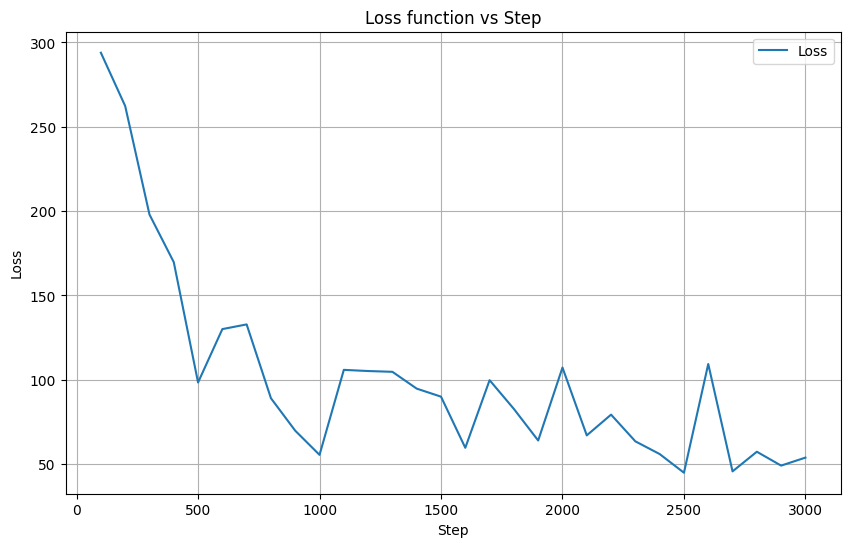

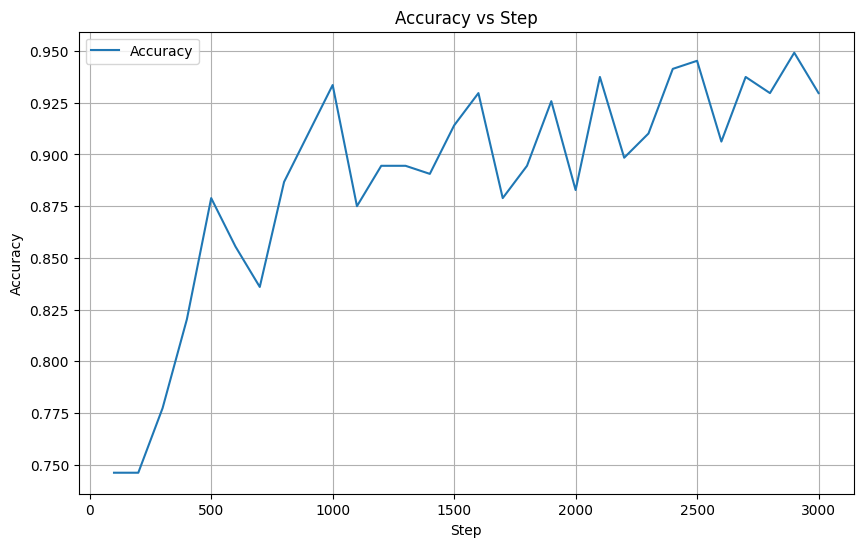

In [100]:
# Виведіть графіки залежності зміни точності і втрат від кроку
# Якщо все зроблено правильно, то точність повинна зростати, а втрати зменшуватись

import matplotlib.pyplot as plt

# Виведіть графік функції втрат
plt.figure(figsize=(10, 6))
plt.plot(range(100, 3001, 100), loss_history, linestyle="-", label='Loss')
plt.title(f'Loss function vs Step')
plt.xlabel('Step')
plt.ylabel(f'Loss')
plt.grid(True)
plt.legend()
plt.show()

# Виведіть графік точності
plt.figure(figsize=(10, 6))
plt.plot(range(100, 3001, 100), accuracy_history, linestyle="-", label='Accuracy')
plt.title(f'Accuracy vs Step')
plt.xlabel('Step')
plt.ylabel(f'Accuracy')
plt.grid(True)
plt.legend()
plt.show()

In [101]:
# Обчисліть точність навченої нейромережі
nn_accuracy_train = accuracy(neural_net(x_train), y_train)

# Тестування моделі на тестових даних
nn_accuracy_test = accuracy(neural_net(x_test), y_test)

print(f"Accuracy on train data: {nn_accuracy_train:.4f}")
print(f"Accuracy on test  data: {nn_accuracy_test:.4f}")

Accuracy on train data: 0.9254
Accuracy on test  data: 0.9092


In [106]:
y_pred = neural_net(x_test).numpy()
y_pred_classes = np.argmax(y_pred, axis=1)

# Convert class indices to class labels (strings)
class_labels = [str(i) for i in range(num_classes)]

print("\nClassification Report:")
print(classification_report(y_test, y_pred_classes, target_names=class_labels))


Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.96      0.95       980
           1       0.97      0.98      0.98      1135
           2       0.92      0.88      0.90      1032
           3       0.89      0.90      0.89      1010
           4       0.89      0.91      0.90       982
           5       0.88      0.86      0.87       892
           6       0.93      0.94      0.93       958
           7       0.91      0.91      0.91      1028
           8       0.89      0.87      0.88       974
           9       0.86      0.88      0.87      1009

    accuracy                           0.91     10000
   macro avg       0.91      0.91      0.91     10000
weighted avg       0.91      0.91      0.91     10000



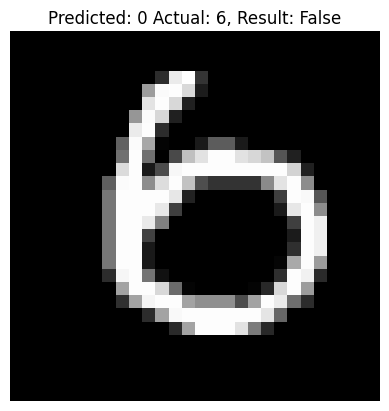

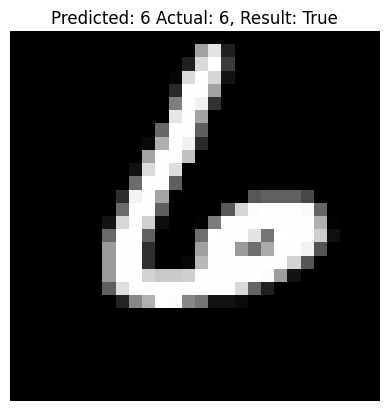

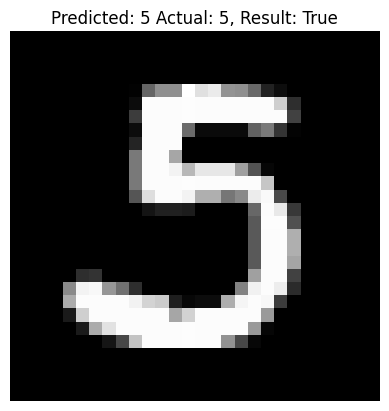

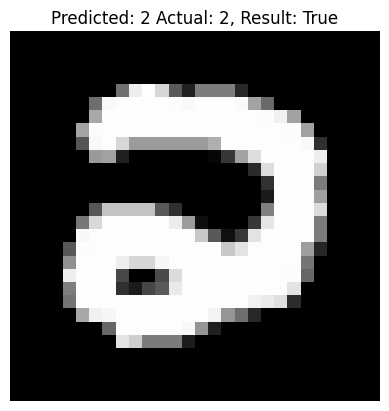

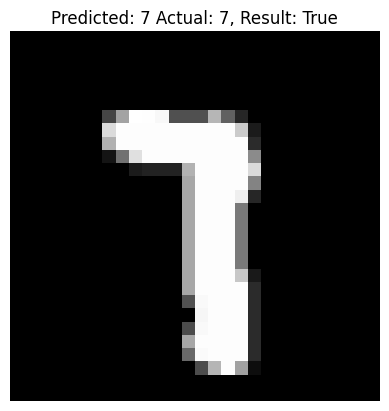

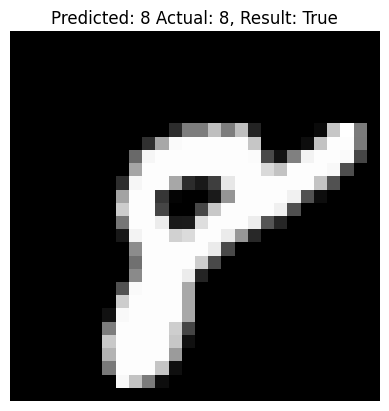

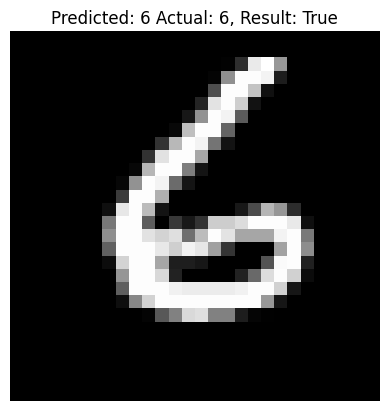

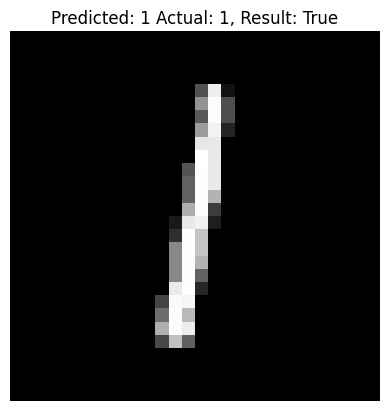

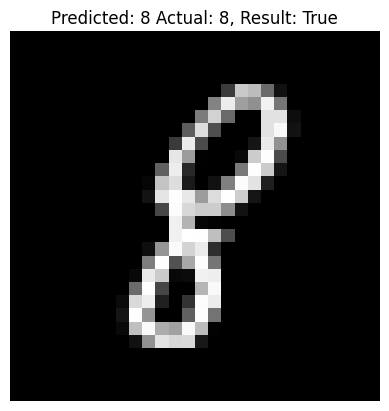

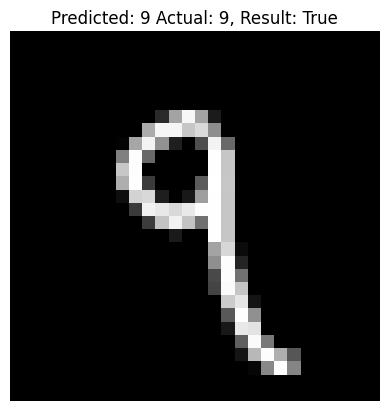

Total Images Tested: 10
Correct Predictions: 9
Error Rate: 0.1000


In [102]:
# Протестуйте навчену нейромережу на 10 зображеннях. З тестової вибірки візьміть 5
# випадкових зображень і передайте їх у нейронну мережу.
# Виведіть зображення та випишіть  поруч відповідь нейромережі.
# Зробіть висновок про те, чи помиляється твоя нейронна мережа, і якщо так, то як часто?

images_to_show = 10  # number of images to test
correct_predictions = 0

random_indexes = random.sample(range(0, len(x_test)), images_to_show)

for i in random_indexes:
    test_image = x_test[i].reshape(28, 28)
    test_image_flattened = x_test[i].reshape(1, 784)

    prediction = neural_net(test_image_flattened)
    predicted_class = np.argmax(prediction.numpy())
    actual_class = y_test[i]
    result = predicted_class == actual_class

    if predicted_class == actual_class:
        correct_predictions += 1

    plt.imshow(test_image, cmap='gray')
    plt.title(f"Predicted: {predicted_class} Actual: {actual_class}, Result: {result}")
    plt.axis('off')
    plt.show()

error_rate = (images_to_show - correct_predictions) / images_to_show
print(f"Total Images Tested: {images_to_show}")
print(f"Correct Predictions: {correct_predictions}")
print(f"Error Rate: {error_rate:.4f}")

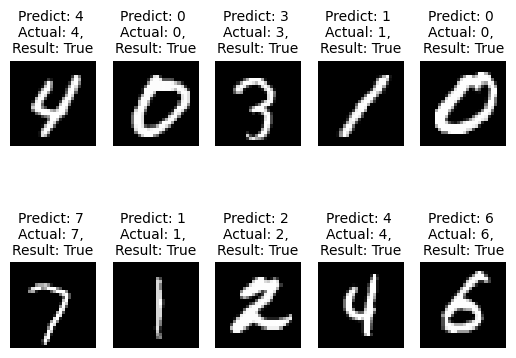

Total Images Tested: 10
Correct Predictions: 10
Error Rate: 0.0000


In [115]:
# Протестуйте навчену нейромережу на 10 зображеннях. З тестової вибірки візьміть 5
# випадкових зображень і передайте їх у нейронну мережу.
# Виведіть зображення та випишіть  поруч відповідь нейромережі.
# Зробіть висновок про те, чи помиляється твоя нейронна мережа, і якщо так, то як часто?

images_to_show = 10  # number of images to test
correct_predictions = 0
p = 0

random_indexes = random.sample(range(0, len(x_test)), images_to_show)

for i in random_indexes:
    p += 1
    test_image = x_test[i].reshape(28, 28)
    test_image_flattened = x_test[i].reshape(1, 784)

    prediction = neural_net(test_image_flattened)
    predicted_class = np.argmax(prediction.numpy())
    actual_class = y_test[i]
    result = predicted_class == actual_class

    if predicted_class == actual_class:
        correct_predictions += 1

    plt.subplot(2, 5, p)
    plt.imshow(test_image, cmap='gray')
    plt.title(f"Predict: {predicted_class} \nActual: {actual_class}, \nResult: {result}", fontsize=10)
    plt.axis('off')

plt.show()

error_rate = (images_to_show - correct_predictions) / images_to_show
print(f"Total Images Tested: {images_to_show}")
print(f"Correct Predictions: {correct_predictions}")
print(f"Error Rate: {error_rate:.4f}")

## Звіт про нейронну мережу

**Опис завдання:**

Створити повнозв'язну нейронну мережу для розпізнавання рукописних цифр з датасету MNIST.

**Архітектура мережі:**

* Вхідний шар: 784 нейрона (28 * 28 пікселів)
* 2 прихованих шари:
    * 128 нейронів з активацією sigmoid
    * 256 нейронів з активацією sigmoid
* Вихідний шар: 10 нейронів (кількість класів) з активацією softmax

**Навчання:**

* Алгоритм: стохастичний градієнтний спуск
* Швидкість навчання: 0.001
* Кількість епох: 3000
* Розмір батчу: 256
* Функція втрат: крос-ентропія
* Метрика: точність

**Результати:**

* Точність на навчальному наборі: 92.54%
* Точність на тестовому наборі: 90.92%

**Оцінка метрик якості для кожного класу:**

| Клас | Precision | Recall | F1-score | Support |
|---|---|---|---|---|
| 0 | 0.93 | 0.96 | 0.95 | 980 |
| 1 | 0.97 | 0.98 | 0.98 | 1135 |
| 2 | 0.92 | 0.88 | 0.90 | 1032 |
| 3 | 0.89 | 0.90 | 0.89 | 1010 |
| 4 | 0.89 | 0.91 | 0.90 | 982 |
| 5 | 0.88 | 0.86 | 0.87 | 892 |
| 6 | 0.93 | 0.94 | 0.93 | 958 |
| 7 | 0.91 | 0.91 | 0.91 | 1028 |
| 8 | 0.89 | 0.87 | 0.88 | 974 |
| 9 | 0.86 | 0.88 | 0.87 | 1009 |

**Accuracy:** 0.91 (10000 зображень)

**Macro avg:** 0.91 (precision, recall, f1-score)

**Weighted avg:** 0.91 (precision, recall, f1-score)

### **Висновок:**

Нейронна мережа успішно навчилася розпізнавати рукописні цифри з MNIST. Досягнута висока точність на тестовому наборі (90.92%) свідчить про те, що модель добре працює на нових даних.

**Аналіз метрик якості:**

Модель демонструє високу продуктивність на всіх 10 класах цифр. Precision, recall та F1-score для більшості класів знаходяться вище 0.9, що свідчить про точне та стійке розпізнавання. Найкращі результати отримані для класів 1, 7 та 6, де всі три метрики досягають 0.98. Найгірші результати спостерігаються для класу 5, де precision, recall та F1-score трохи нижчі, але все ж таки залишаються на високому рівні (0.88, 0.86 та 0.87 відповідно).

**Загальна оцінка:**

Ця нейронна мережа є потужним інструментом для розпізнавання рукописних цифр. Її висока точність та стійкість до різних класів робить її придатним рішенням для практичних задач.

**Можливі покращення:**

* **Експерименти з архітектурою:** Можна спробувати інші архітектури нейронної мережі, наприклад, з більшою кількістю шарів або нейронів
* **Експерименти з активаційними функціями:** Можна замінити функції активації sigmoid в прихохованих шарах на інші, такі як ReLU або leaky ReLU, які можуть допомогти з навчанням мережі.
* **Регуляризація:** Застосування методів регуляризації, таких як L1 або L2 регуляризація, може допомогти запобігти перенавчанню та покращити узагальнення моделі на нових даних.
* **Оптимізатори:** Можна спробувати інші оптимізатори, такі як Adam або RMSprop, які можуть допомогти прискорити навчання або досягти кращої точності.
* **Додаткова обробка даних:** Попередня обробка даних, наприклад, нормалізація або аугментація зображень, може покращити продуктивність моделі.

**Підсумок:**

Хоча дана нейронна мережа вже демонструє хорошу продуктивність, є багато можливостей для її подальшого покращення. Експериментуючи з різними налаштуваннями та методами, можна потенційно підвищити точність та стійкість моделі.
